### Bike-Sharing Case study

##### Overview

The procedure of gaining membership, renting a bike, and returning it is all automated with the use of a network of kiosk locations spread out around a city in bike sharing systems. These systems let users to hire a bike from one spot and drop it off at an other one as needed. There are currently more than 500 bike-sharing programmes operating worldwide.

##### Objecctive

This research aims to estimate the demand for bike rentals by fusing past bike usage patterns with weather information.

Target column to be predicted: 'count'


### Linear regression steps followed

1. Data Overview

      - Understanding and loading of Data


2. Data Preperation

    - a) Fix Rows and Columns
    - b) Missing Value check
    - c) Outlier detection
    

3. Data Visualization

      - Univariate Analysis
      - Bivariate Analysis

4. Data Encoding 
      - Binary variable
      - dummy variable
  
5. Preparing the model 

      - Train-test split
      - rescalling

6. Building the  model

      - Recursive Feature Estimation
      - Manual Approach
 
7. Residual Analysis


8. Prediction and evaluation on test set
  

### 1. Data Overview

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
# Check for the VIF values of the feature variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#READ DATA
Bike_df=pd.read_csv("day.csv")
Bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
Bike_df.shape

(730, 16)

Bike_df.info()

In [4]:
#To check columns present in dataset
print(Bike_df.columns)

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


### 2. Data Preperation

      - a) Fix Rows and Columns
      - b) Missing Value check
      - c) Outlier Detection
      

In [5]:
# instant is an index column so we drop it
Bike_df.drop(['instant'],axis=1,inplace=True)
# since dteday and year have the same value droping it
Bike_df.drop(['dteday'],axis=1,inplace=True)
# casual+registered=cnt and cnt is our target variable therefore casual and Registered is dropped
Bike_df.drop(['casual','registered'],axis=1,inplace=True)



In [6]:
Bike_df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

##### Categorical variables are replaced with appropriate values
###### categorical columns=[yr,mnth,season,weekday,workingday,weathersit]

In [7]:
Bike_df['season'].replace({1:"spring",2:"summer",3:"fall",4:"winter"},inplace=True)
Bike_df['weekday'].replace({0:"Sunday",1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thursday",5:"Friday",6:"Saturday"},inplace=True)
Bike_df['mnth'].replace({1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"},inplace=True)
Bike_df["weathersit"].replace({1:'Clear', 2:'Misty+Cloudy', 3:'Light Snow/Rain', 4:'Heavy Snow/Rain'},inplace=True)

In [8]:
print("season \n",Bike_df['season'].value_counts())
print("\n weekday \n",Bike_df['weekday'].value_counts())
print("\n mnth \n",Bike_df['mnth'].value_counts())
print("\n weathersit \n",Bike_df["weathersit"].value_counts())

season 
 fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

 weekday 
 Saturday     105
Sunday       105
Monday       105
Tuesday      104
Thursday     104
Friday       104
Wednesday    103
Name: weekday, dtype: int64

 mnth 
 January      62
March        62
May          62
July         62
August       62
October      62
December     62
April        60
June         60
September    60
November     60
February     56
Name: mnth, dtype: int64

 weathersit 
 Clear              463
Misty+Cloudy       246
Light Snow/Rain     21
Name: weathersit, dtype: int64


In [9]:
Bike_df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,January,0,Saturday,0,Misty+Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,January,0,Sunday,0,Misty+Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,January,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,January,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,January,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


<AxesSubplot:>

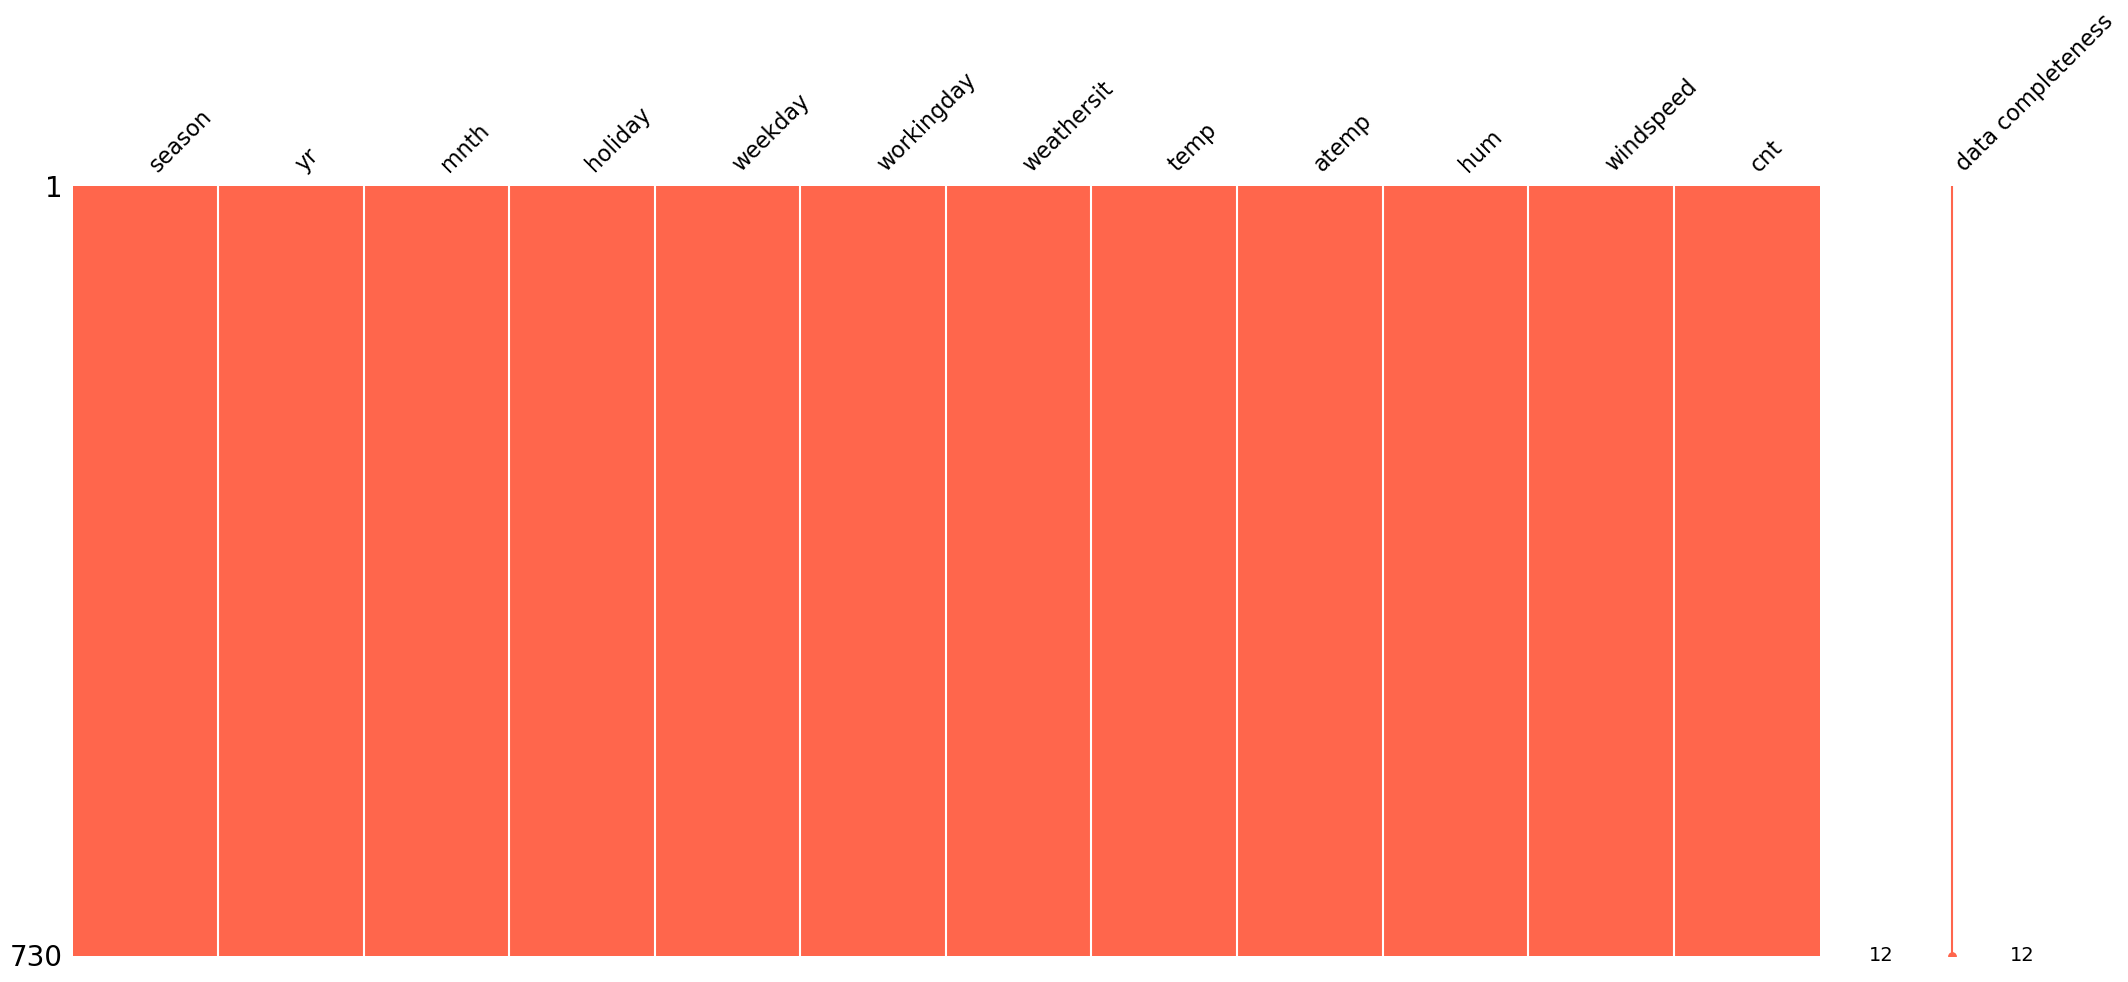

In [10]:
# Missing Value Check
import missingno as msno
%matplotlib inline
msno.matrix(Bike_df,labels=True,sort="ascending",color=(1,0.4,0.3))


- based on the above analysis

 -there are no null values in the data frame

In [11]:
def Col_types(dataframe):
    dataframe_numerical=dataframe.select_dtypes(exclude="object")
    dataframe_categorical=dataframe.select_dtypes(include="object")
    
    return dataframe_numerical,dataframe_categorical
continuous_columns,categorical_columns  = Col_types(Bike_df)
print("categorical_columns:=",categorical_columns.columns.tolist(), "\n continuous_columns:=",continuous_columns.columns.tolist())

categorical_columns:= ['season', 'mnth', 'weekday', 'weathersit'] 
 continuous_columns:= ['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


In [12]:
Bike_df.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,0.683562,20.319259,23.726322,62.765175,12.763620,4508.006849
std,0.500343,0.167266,0.465405,7.506729,8.150308,14.237589,5.195841,1936.011647
min,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,0.000000,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,0.500000,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,1.000000,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,1.000000,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


**Outlier detection**

In [13]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    outlier_length=0
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    outliers_values=((dataframe[col_name] < (low_limit)) |(dataframe[col_name] > (up_limit)))
    outlier_length=len(dataframe[outliers_values])
    if dataframe[outliers_values].any(axis=None):
        return True,outlier_length
    else:
        return False,outlier_length

In [14]:
for col in continuous_columns:
        print(f"{col} :  {check_outlier(Bike_df, col)}")

yr :  (False, 0)
holiday :  (True, 21)
workingday :  (False, 0)
temp :  (False, 0)
atemp :  (False, 0)
hum :  (False, 0)
windspeed :  (True, 1)
cnt :  (False, 0)


In [15]:
Bike_df["holiday"].value_counts()

0    709
1     21
Name: holiday, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x215aaccf460>,
 'caps': [<matplotlib.lines.Line2D at 0x215aaccf9a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x215aaccf190>],
 'medians': [<matplotlib.lines.Line2D at 0x215aaccff40>],
 'fliers': [<matplotlib.lines.Line2D at 0x215aacdd250>],
 'means': []}

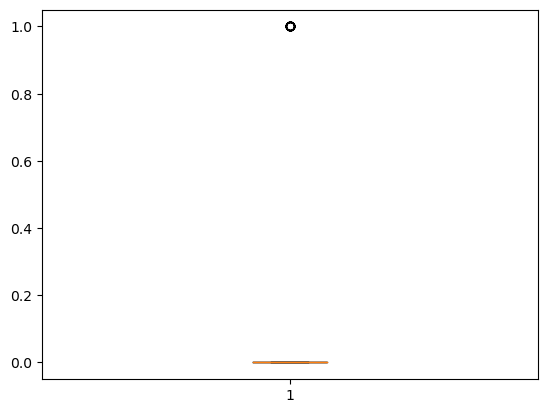

In [16]:
##feature holiday
plt.boxplot(Bike_df["holiday"])

In [17]:
Bike_df.windspeed.quantile([0.5,0.75,0.90,0.95,0.97,0.975, 0.98,0.985, 0.99, 1.0])

0.500    12.125325
0.750    15.625589
0.900    19.833997
0.950    22.999988
0.970    23.999167
0.975    24.443863
0.980    25.201627
0.985    25.922433
0.990    27.380948
1.000    34.000021
Name: windspeed, dtype: float64

### Insights on Data Overview and Data Preperation
##### 1. There were no missing values in any of the feature set

##### 2. Only 2 features (Holiday and Windspeed) were discovered to be having outliers based on outlier identification.
         - Feature Holiday is not condidered since it has only 2 values 1 and 0 
         - With the exception of one number of 34, which is deemed to be acceptable, all of the values for the feature windspeed are continuous.
         - Hence no features were capped.
         
##### 3. Category variables were replaced with appropriate string values


## 3. Data Visualization ###


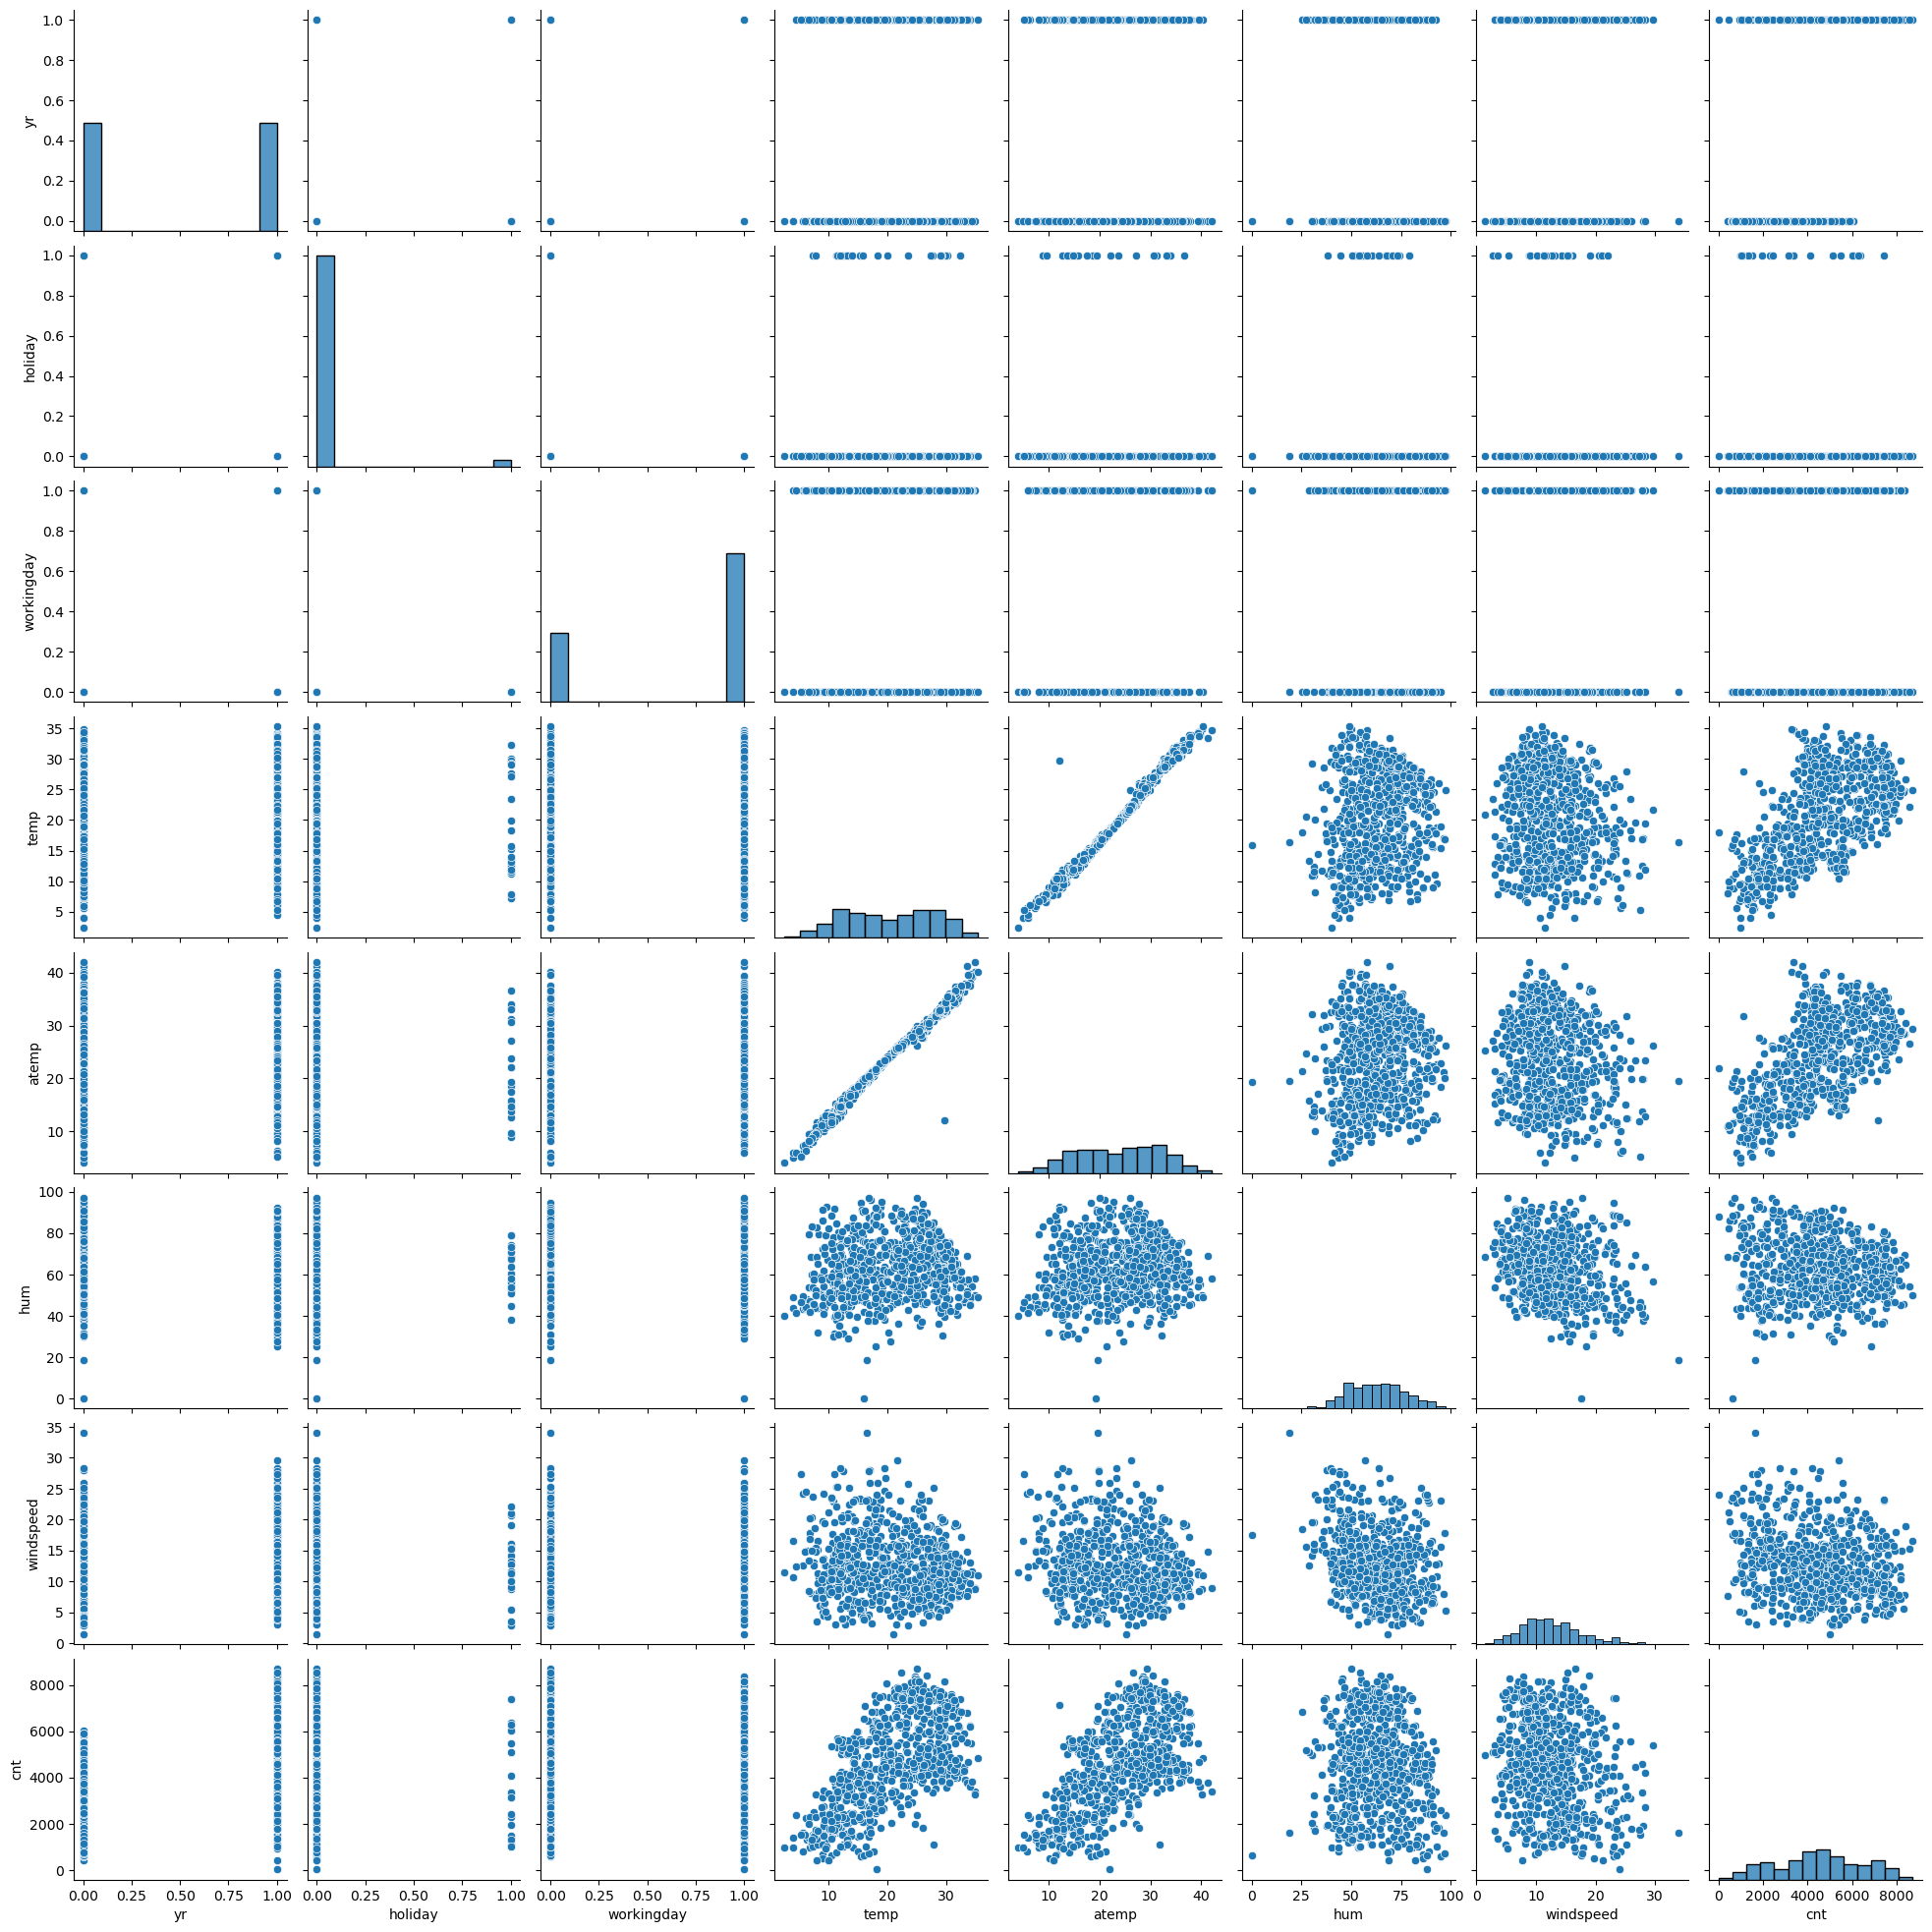

In [18]:
sns.pairplot(Bike_df)

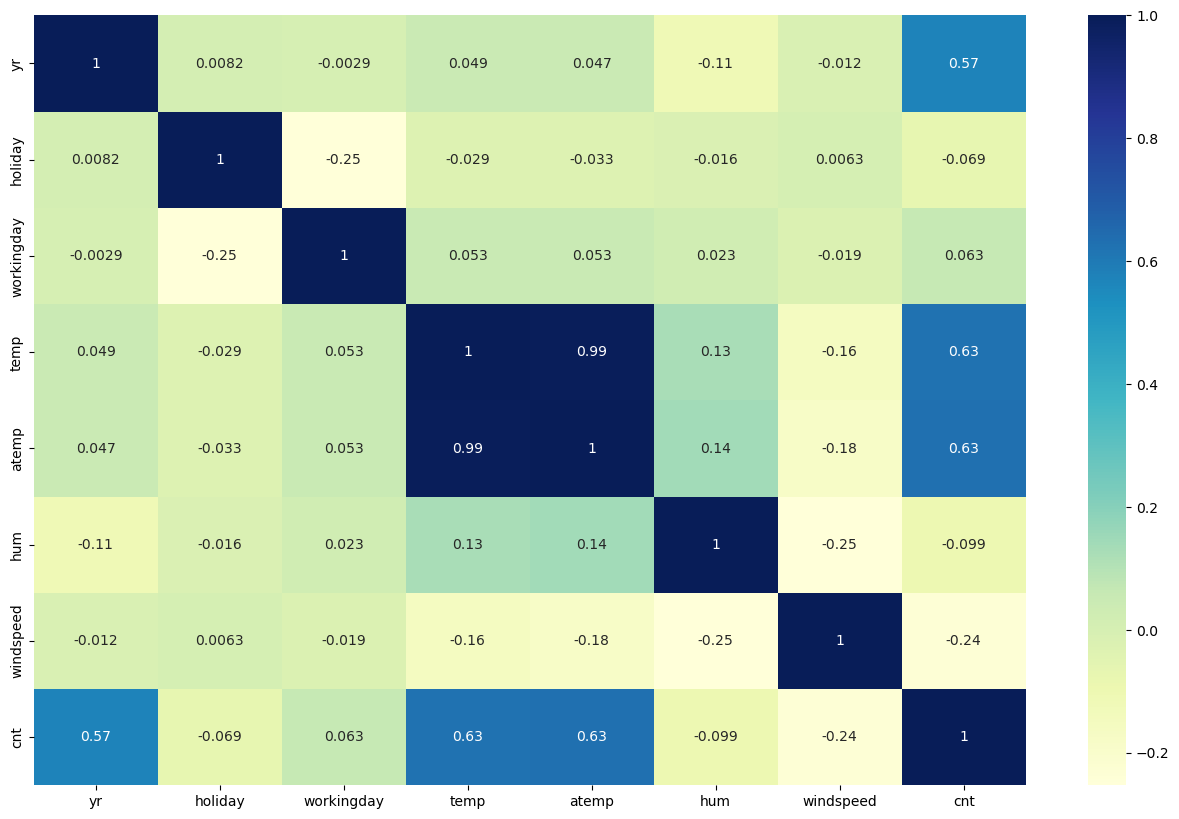

In [19]:
#let check the correlation
plt.figure(figsize = (16, 10))
sns.heatmap(Bike_df.corr(), annot = True, cmap="YlGnBu")
plt.show()

#### Inference from heatmap
##### Maximum correlation between temp and atemp i.e 0.99
##### High positive correlation between temp and count  and atemp and count
##### High negative correlation between humidity and count.

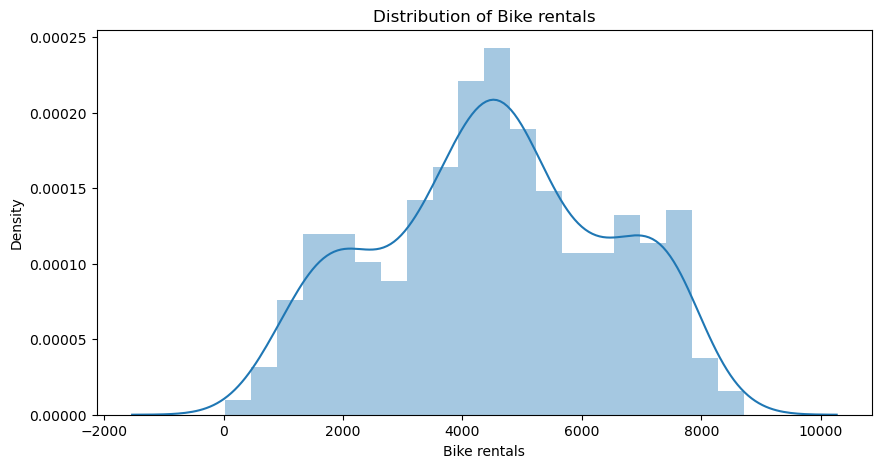

In [76]:
# Distribution of Bike rentals
plt.figure(figsize=(10,5))
sns.distplot(Bike_df.cnt,kde=True, bins=20)
plt.xlabel('Bike rentals')
plt.ylabel('Density')
plt.title('Distribution of Bike rentals',fontsize=12)
plt.show()

##### The largest frequency of bike rentals is between 4,000 and 6,000.  

### Analysing target variable Cnt across different categories

###### Cnt-Target Variable

   - vs Season
   
   - vs Weekday
   
   - vs Weathersit
   
   - vs month
   
   - vs Yr
   
   - vs Workingday

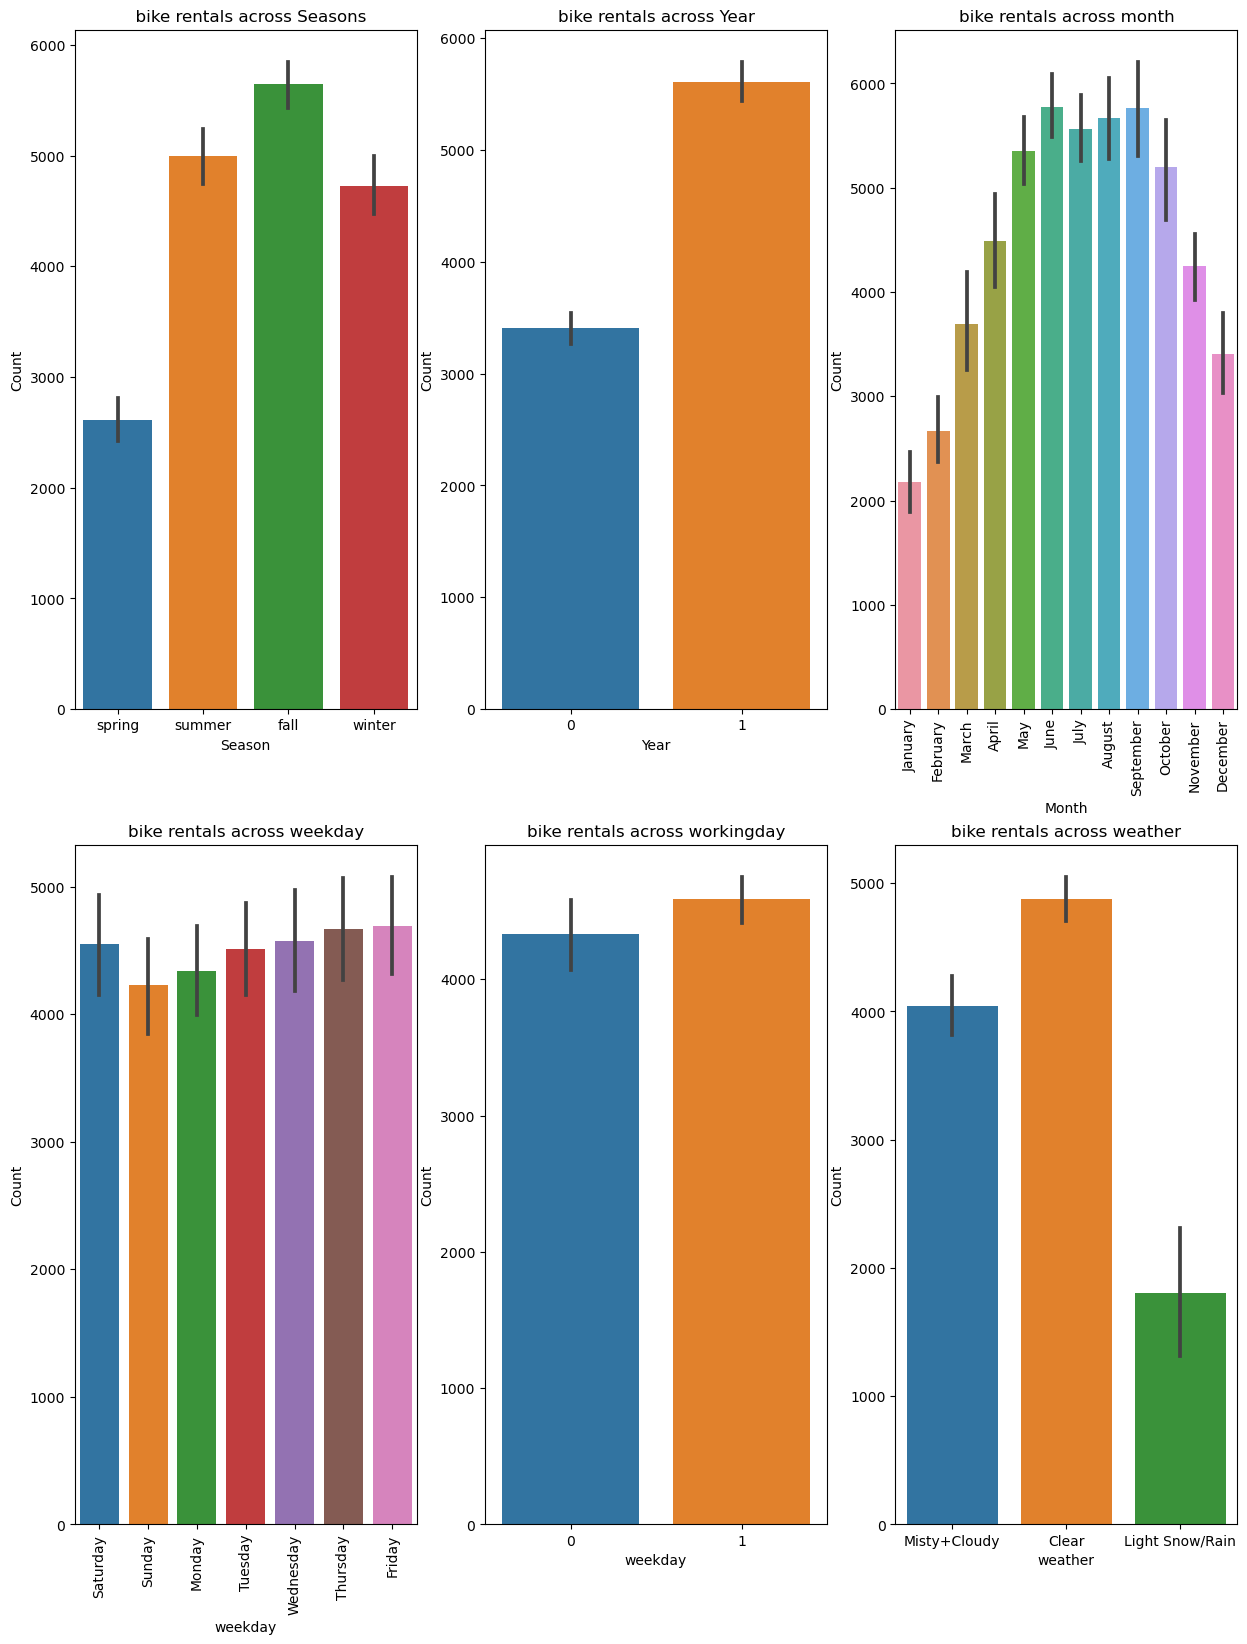

In [21]:
plt.figure(figsize=(15, 30))
plt.subplot(331)

axes=sns.barplot(data=Bike_df, x=Bike_df.season, y=Bike_df.cnt)
axes.set(xlabel='Season', ylabel='Count', title="  bike rentals across Seasons")

plt.subplot(332)
axes=sns.barplot(data=Bike_df, x=Bike_df.yr, y=Bike_df.cnt)
axes.set(xlabel='Year', ylabel='Count', title="bike rentals across Year")


plt.subplot(333)
axes=sns.barplot(data=Bike_df, x=Bike_df.mnth, y=Bike_df.cnt)
axes.set(xlabel='Month', ylabel='Count', title="bike rentals across month")
plt.xticks(rotation=90)

plt.subplot(334)
axes=sns.barplot(data=Bike_df, x=Bike_df.weekday, y=Bike_df.cnt)
axes.set(xlabel='weekday', ylabel='Count', title="bike rentals across weekday")
plt.xticks(rotation=90)

plt.subplot(335)
axes=sns.barplot(data=Bike_df, x=Bike_df.workingday, y=Bike_df.cnt)
axes.set(xlabel='weekday', ylabel='Count', title="bike rentals across workingday")

plt.subplot(336)
axes=sns.barplot(data=Bike_df, x=Bike_df.weathersit, y=Bike_df.cnt)
axes.set(xlabel='weather', ylabel='Count', title="bike rentals across weather")

plt.show()

<AxesSubplot:xlabel='holiday', ylabel='cnt'>

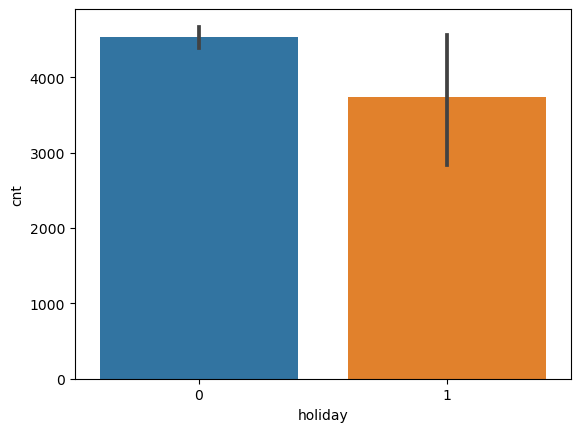

In [22]:
sns.barplot(x="holiday",y="cnt",data=Bike_df)


### Data Visualization Insights
###### 1. During the autumn, which normally starts in September, the majority of men and women who have rented motorcycles have done so.Therefore, people prefer to travel when the weather is clear.
###### 2. The majority of people have leased bikes during the workday. They probably prefer riding a motorbike to work.
###### 3. The busiest days for bike rentals were Friday and Saturday.
###### 4. The number of bike rentals has significantly increased in 2019. Probably as a result of the beneficial effects it had on individuals the year before
###### 5. Myriad of people rentend Bike during National Holiday.
###### 6.The largest frequency of bike rentals is between 4,000 and 6,000.  
###### 7. Maximum correlation between temp and atemp i.e 0.99.
###### 8. High positive correlation between temp and count  and atemp and count
###### 9. High negative correlation between humidity and count.

### 4.Data Encoding ###
     
     - Dummy Variable
     it can be applied to the feature that has more than 2 values
     it uses the k-1 dummy variable
     

In [23]:
Bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 68.6+ KB


In [24]:
#### DUMMY Encoding
status=pd.get_dummies(Bike_df["season"],drop_first=True)
status.head()


,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [25]:
Bike_df=pd.concat([status,Bike_df],axis=1)
Bike_df= Bike_df.drop('season',axis=1)
Bike_df.head()

,spring,summer,winter,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,0,0,January,0,Saturday,0,Misty+Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,1,0,0,0,January,0,Sunday,0,Misty+Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,1,0,0,0,January,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,0,0,January,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,0,0,January,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [26]:
status=pd.get_dummies(Bike_df["mnth"],drop_first=True)
Bike_df=pd.concat([status,Bike_df],axis=1)
Bike_df= Bike_df.drop('mnth',axis=1)
Bike_df.head()

,August,December,February,January,July,June,March,May,November,October,...,yr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,0,0,0,1,0,0,0,0,0,0,...,0,0,Saturday,0,Misty+Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,0,0,0,1,0,0,0,0,0,0,...,0,0,Sunday,0,Misty+Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,0,0,0,1,0,0,0,0,0,0,...,0,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,0,0,0,1,0,0,0,0,0,0,...,0,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,0,0,0,1,0,0,0,0,0,0,...,0,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [27]:
status=pd.get_dummies(Bike_df["weekday"],drop_first=True)
Bike_df=pd.concat([status,Bike_df],axis=1)
Bike_df= Bike_df.drop('weekday',axis=1)
Bike_df.head()

,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,August,December,February,January,...,winter,yr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,Misty+Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,Misty+Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [28]:
status=pd.get_dummies(Bike_df["weathersit"],drop_first=True)
Bike_df=pd.concat([status,Bike_df],axis=1)
Bike_df= Bike_df.drop('weathersit',axis=1)
Bike_df.head()

,Light Snow/Rain,Misty+Cloudy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,August,December,...,summer,winter,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt
0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,14.110847,18.18125,80.5833,10.749882,985
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,14.902598,17.68695,69.6087,16.652113,801
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,8.050924,9.47025,43.7273,16.636703,1349
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,8.200000,10.60610,59.0435,10.739832,1562
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,9.305237,11.46350,43.6957,12.522300,1600


### 5.Preparing the model
      - 1. Train-Test Split
      - 2. Rescalling the features


###### splitting the data into Train and Test data set

In [29]:
Bike_df_train,Bike_df_test=train_test_split(Bike_df,train_size=0.7,test_size=0.3,random_state=100)
print(Bike_df_train.shape,Bike_df_test.shape)

(510, 30) (219, 30)


###### Rescaling the numerical features

In [30]:
# Scaler is applied to all the columns except for the Feature that has 0 or 1(dummy and binary)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
num_columns= ['temp','atemp', 'hum', 'windspeed', 'cnt']
## fir_transform : will learn xmin and x max as well as it computes(x-xmin)/(xmax-xmin)
Bike_df_train[num_columns]=scaler.fit_transform(Bike_df_train[num_columns])
Bike_df_train[num_columns].describe()

,temp,atemp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.537262,0.512989,0.650369,0.320768,0.513620
std,0.225844,0.212385,0.145882,0.169797,0.224593
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.332086,0.538643,0.199179,0.356420
50%,0.540519,0.526811,0.653714,0.296763,0.518638
75%,0.735215,0.688457,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000


###### all the values are between 0 and 1 since we applied min max scaler

In [31]:
# Dividing x and y sets for model buildinh
y_train = Bike_df_train.pop('cnt') # it will asign the cnt to the ytrain
X_train = Bike_df_train # all the features other than cnt will be assigned to x_train

In [32]:
X_train

,Light Snow/Rain,Misty+Cloudy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,August,December,...,spring,summer,winter,yr,holiday,workingday,temp,atemp,hum,windspeed
653,0,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,1,0.509887,0.501133,0.575354,0.300794
576,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0.815169,0.766351,0.725633,0.264686
426,0,1,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0.442393,0.438975,0.640189,0.255342
728,0,0,0,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0.245101,0.200348,0.498067,0.663106
482,0,1,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0.395666,0.391735,0.504508,0.188475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,0,1,1,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0.824514,0.762183,0.605840,0.355596
578,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0.863973,0.824359,0.679690,0.187140
53,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0.202618,0.218747,0.435939,0.111379
350,0,1,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0.248216,0.223544,0.577930,0.431816


In [33]:
X_train.describe()

,Light Snow/Rain,Misty+Cloudy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,August,December,...,spring,summer,winter,yr,holiday,workingday,temp,atemp,hum,windspeed
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.00000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.029412,0.343137,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.096078,0.084314,...,0.243137,0.245098,0.24902,0.507843,0.025490,0.676471,0.537262,0.512989,0.650369,0.320768
std,0.169124,0.475223,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.294988,0.278131,...,0.429398,0.430568,0.43287,0.500429,0.157763,0.468282,0.225844,0.212385,0.145882,0.169797
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.540519,0.526811,0.653714,0.296763
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 6.Building the model
      - Hybrid model
    

##### RFE
###### Recursive feature elimination

In [34]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
lm=LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [35]:
rfe=RFE(estimator=lm,n_features_to_select=15)
rfe=rfe.fit(X_train,y_train)

In [36]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Light Snow/Rain', True, 1),
 ('Misty+Cloudy', True, 1),
 ('Monday', False, 7),
 ('Saturday', True, 1),
 ('Sunday', False, 6),
 ('Thursday', False, 11),
 ('Tuesday', False, 14),
 ('Wednesday', False, 10),
 ('August', False, 12),
 ('December', False, 2),
 ('February', True, 1),
 ('January', True, 1),
 ('July', True, 1),
 ('June', False, 13),
 ('March', False, 4),
 ('May', False, 8),
 ('November', False, 3),
 ('October', False, 5),
 ('September', True, 1),
 ('spring', False, 15),
 ('summer', True, 1),
 ('winter', True, 1),
 ('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 9),
 ('hum', True, 1),
 ('windspeed', True, 1)]

In [37]:
col=X_train.columns[rfe.support_]
col

Index(['Light Snow/Rain', 'Misty+Cloudy', 'Saturday', 'February', 'January',
       'July', 'September', 'summer', 'winter', 'yr', 'holiday', 'workingday',
       'temp', 'hum', 'windspeed'],
      dtype='object')

In [38]:
X_train.columns[~rfe.support_]

Index(['Monday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'August',
       'December', 'June', 'March', 'May', 'November', 'October', 'spring',
       'atemp'],
      dtype='object')

In [39]:
# Generic function to calculate VIF of variables

def calculateVIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif 

#### The following factors are used to decide ,on which feature should be removed::
##### pvalue less than 0.005
##### VIF less than 5
##### R2 should be more than 50%



###### Building model using statsmodel, for the detailed statistics

In [40]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [41]:
calculateVIF(X_train_rfe)

,Features,VIF
13,hum,22.67
12,temp,14.50
11,workingday,5.15
14,windspeed,4.04
8,winter,2.33
1,Misty+Cloudy,2.17
9,yr,2.07
7,summer,2.05
2,Saturday,1.93
4,January,1.80


##### only const has high value

In [42]:
# # Building 1st linear regression model
X_train_lm1=sm.add_constant(X_train_rfe)
lm1=sm.OLS(y_train,X_train_rfe).fit()

In [43]:
print(lm1.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1200.
Date:                Tue, 20 Jun 2023   Prob (F-statistic):                        0.00
Time:                        18:45:43   Log-Likelihood:                          494.88
No. Observations:                 510   AIC:                                     -959.8
Df Residuals:                     495   BIC:                                     -896.2
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [44]:
#####  Based on the summary and VIF, dropping Humidity as it is highly insignificant(0.890) and has high VIF value(22.67)(MULTICOLLINEARITY)

X = X_train_rfe.drop('hum', axis=1)

In [45]:
# Run the function to calculate VIF for the new model
calculateVIF(X)

,Features,VIF
12,temp,7.02
11,workingday,4.89
13,windspeed,4.01
9,yr,2.06
7,summer,1.95
2,Saturday,1.87
8,winter,1.68
1,Misty+Cloudy,1.57
5,July,1.54
4,January,1.39


In [47]:
# Build a second  linear regression model
X_train_lm2 = sm.add_constant(X)

lm2 = sm.OLS(y_train, X_train_lm2).fit()
# Print the summary of the model
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     187.7
Date:                Tue, 20 Jun 2023   Prob (F-statistic):          1.26e-187
Time:                        18:49:57   Log-Likelihood:                 508.22
No. Observations:                 510   AIC:                            -986.4
Df Residuals:                     495   BIC:                            -922.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1252      0.024     

In [48]:
# We can drop February since it is having high p value 0.121
X = X.drop(['February'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X)

,Features,VIF
11,temp,6.83
10,workingday,4.71
12,windspeed,3.67
8,yr,2.05
2,Saturday,1.85
6,summer,1.82
7,winter,1.57
1,Misty+Cloudy,1.56
4,July,1.53
3,January,1.31


In [49]:
# Building 3rd linear regression model

X_train_lm3 = sm.add_constant(X)
lm3 = sm.OLS(y_train,X_train_lm3).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     201.4
Date:                Tue, 20 Jun 2023   Prob (F-statistic):          2.88e-188
Time:                        18:52:20   Log-Likelihood:                 506.98
No. Observations:                 510   AIC:                            -986.0
Df Residuals:                     496   BIC:                            -926.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1077      0.022     

In [50]:
# July  variable is dropeed since it has high p-value
X = X.drop(['July'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X)

,Features,VIF
10,temp,5.23
9,workingday,4.68
11,windspeed,3.66
7,yr,2.05
2,Saturday,1.84
5,summer,1.63
1,Misty+Cloudy,1.55
6,winter,1.50
3,January,1.31
4,September,1.21


In [51]:
# Building 4th linear regression model

X_train_lm4 = sm.add_constant(X)
lm4 = sm.OLS(y_train,X_train_lm4).fit()
print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     216.4
Date:                Tue, 20 Jun 2023   Prob (F-statistic):          1.64e-188
Time:                        18:53:18   Log-Likelihood:                 504.76
No. Observations:                 510   AIC:                            -983.5
Df Residuals:                     497   BIC:                            -928.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1112      0.022     

In [52]:
# We can drop holiday  variable as it has high p-value(0.043)
X = X.drop(['holiday'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X)

,Features,VIF
9,temp,5.10
8,workingday,4.28
10,windspeed,3.57
7,yr,2.05
2,Saturday,1.75
5,summer,1.63
1,Misty+Cloudy,1.55
6,winter,1.47
3,January,1.29
4,September,1.20


In [53]:
# Building 5th linear regression model

X_train_lm5 = sm.add_constant(X)
lm5 = sm.OLS(y_train,X_train_lm5).fit()
print(lm5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     234.2
Date:                Tue, 20 Jun 2023   Prob (F-statistic):          8.02e-189
Time:                        18:54:29   Log-Likelihood:                 502.67
No. Observations:                 510   AIC:                            -981.3
Df Residuals:                     498   BIC:                            -930.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1022      0.021     

In [54]:
# January is dropped, because its pvalue is not within the permissible range
X = X.drop(['January'], axis = 1)

# Run the function to calculate VIF for the new model
calculateVIF(X)

,Features,VIF
8,temp,4.76
7,workingday,4.04
9,windspeed,3.43
6,yr,2.02
2,Saturday,1.69
4,summer,1.57
1,Misty+Cloudy,1.53
5,winter,1.40
3,September,1.20
0,Light Snow/Rain,1.08


In [55]:
# Building 6th linear regression model

X_train_lm6 = sm.add_constant(X)
lm6 = sm.OLS(y_train,X_train_lm6).fit()
print(lm6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     254.0
Date:                Tue, 20 Jun 2023   Prob (F-statistic):          1.47e-188
Time:                        18:56:56   Log-Likelihood:                 499.18
No. Observations:                 510   AIC:                            -976.4
Df Residuals:                     499   BIC:                            -929.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0753      0.019     

In [56]:
# Run the function to calculate VIF for the new model
calculateVIF(X)

,Features,VIF
8,temp,4.76
7,workingday,4.04
9,windspeed,3.43
6,yr,2.02
2,Saturday,1.69
4,summer,1.57
1,Misty+Cloudy,1.53
5,winter,1.40
3,September,1.20
0,Light Snow/Rain,1.08


##### VIF and Pvlaue are well within the acceptable range and Rsquared is 83%
##### hence considering the obtained model(lm6) for prediction

In [57]:
# Checking the parameters and their coefficient values
print(lm6.params.sort_values(ascending = False))

temp               0.549936
yr                 0.233056
winter             0.131826
September          0.097236
summer             0.087429
const              0.075325
Saturday           0.067688
workingday         0.056323
Misty+Cloudy      -0.081347
windspeed         -0.155238
Light Snow/Rain   -0.288021
dtype: float64


### Residual Analysis

Make predictions about the test set after studying the residuals. This is to ensure that we satisfy the assumptions of the linear regression model.
- Linear relationship between X and Y 
- Error terms are normally distributed .
- Error terms have constant variance (homoscedasticity)
- Error terms are independent of each other


In [58]:
X_train_lm6

,const,Light Snow/Rain,Misty+Cloudy,Saturday,September,summer,winter,yr,workingday,temp,windspeed
653,1.0,0,0,0,0,0,1,1,1,0.509887,0.300794
576,1.0,0,0,0,0,0,0,1,1,0.815169,0.264686
426,1.0,0,1,1,0,0,0,1,0,0.442393,0.255342
728,1.0,0,0,0,0,0,0,1,0,0.245101,0.663106
482,1.0,0,1,1,0,1,0,1,0,0.395666,0.188475
...,...,...,...,...,...,...,...,...,...,...,...
526,1.0,0,1,0,0,1,0,1,1,0.824514,0.355596
578,1.0,0,0,0,0,0,0,1,1,0.863973,0.187140
53,1.0,0,0,0,0,0,0,0,1,0.202618,0.111379
350,1.0,0,1,1,0,0,1,0,0,0.248216,0.431816


#### a) Linear Relationship :
Linear relationship between the feature and the target.Linear relationship can be plotted using the scatter plot


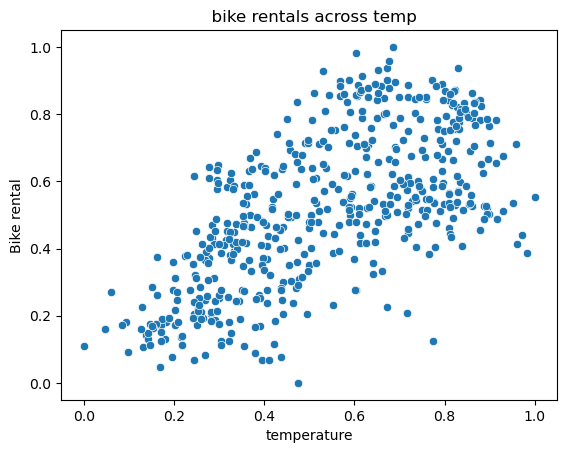

In [59]:
axes=sns.scatterplot(X.temp,y_train)
axes.set(xlabel='temperature', ylabel='Bike rental', title="  bike rentals across temp")
plt.show()

##### Based on the aforementioned analysis, sales of rental bike rise as the temperature rises.

#### b) Normal distribution of Error Terms
Distplot is used to check the uniform distribution error term

In [61]:
y_train_pred=lm6.predict(X_train_lm6)

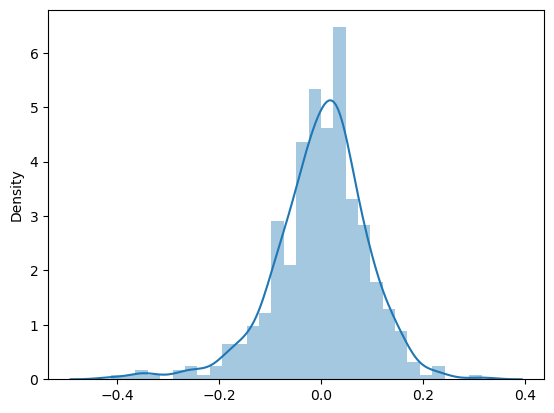

In [63]:
# Plot the histogram of the error terms
residual=y_train-y_train_pred
sns.distplot(residual)
 
plt.show()

###### error terms are normally distributed.

#### c)Homoscedasticity Assumption
Error term is same across all the independent variables.A scatter plot of residual values vs predicted values is used to asertain the homoscedasticity.

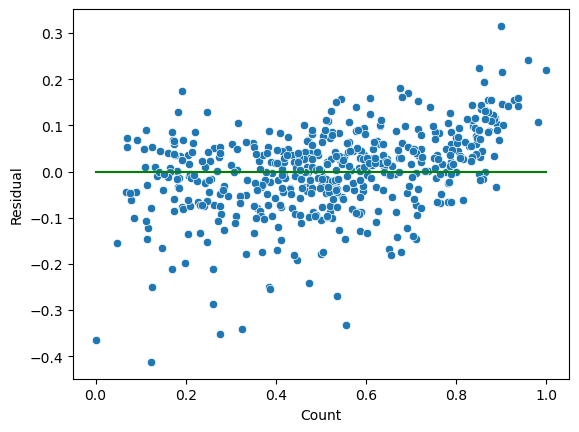

In [64]:
residual = y_train - y_train_pred
sns.scatterplot(y_train,residual)
sns.lineplot([0,1],[0,0],color='g')
plt.xlabel('Count')
plt.ylabel('Residual')
plt.show()

###### the graph shows no specific pattern . there exists common variance among the residuals

###### d) Error terms are independent of each other

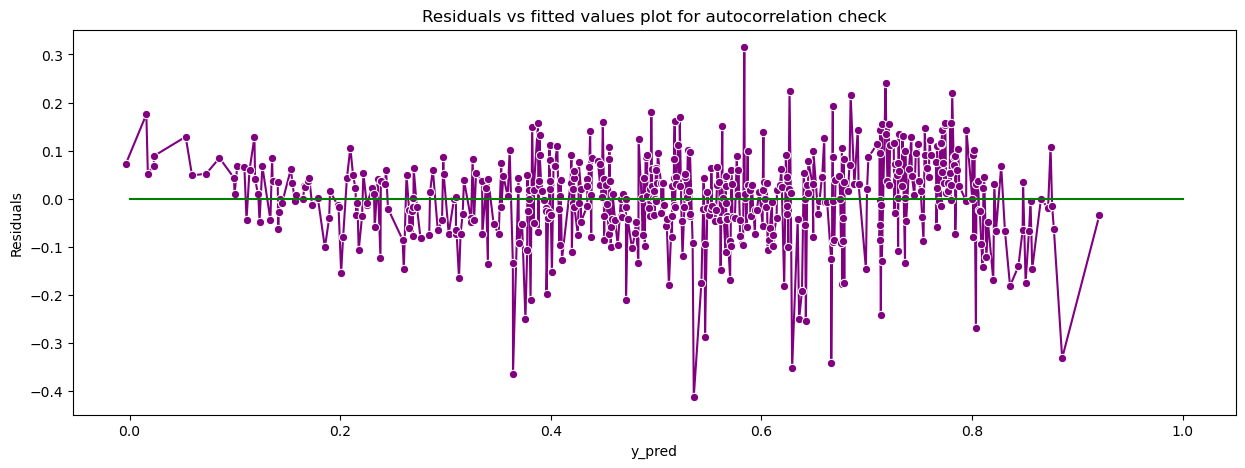

In [65]:
plt.figure(figsize=(15,5))
p = sns.lineplot(y_train_pred,residual,marker='o',color='purple')
plt.xlabel('y_pred')
plt.ylabel('Residuals')
p = sns.lineplot([0,1],[0,0],color='green')
p = plt.title('Residuals vs fitted values plot for autocorrelation check')

##### there is no auto correlation between error term

### Prediction and Evaluation of test model

In [66]:
num_columns= ['temp','atemp', 'hum', 'windspeed', 'cnt']
## transform :it only computes(x-xmin)/(xmax-xmin)
Bike_df_test[num_columns]=scaler.transform(Bike_df_test[num_columns])

In [67]:
Bike_df_test.describe()

,Light Snow/Rain,Misty+Cloudy,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,August,December,...,summer,winter,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.027397,0.319635,0.127854,0.118721,0.146119,0.164384,0.164384,0.100457,0.059361,0.086758,...,0.264840,0.232877,0.479452,0.036530,0.698630,0.558941,0.532991,0.638508,0.313350,0.520592
std,0.163612,0.467403,0.334692,0.324202,0.354034,0.371472,0.371472,0.301297,0.236840,0.282125,...,0.442259,0.423633,0.500722,0.188034,0.459904,0.233698,0.217888,0.148974,0.159947,0.218435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.354650,0.344751,0.527265,0.198517,0.377531
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.558691,0.549198,0.627737,0.299459,0.524275
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.759096,0.714132,0.743928,0.403048,0.672745
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300


In [68]:
y_test = Bike_df_test.pop('cnt')
X_test = Bike_df_test

In [69]:
col1 = X.columns

X_test = X_test[col1]
# Adding constant variable to test dataframe
X_test_lm6 = sm.add_constant(X_test)

In [70]:
y_test_pred = lm6.predict(X_test_lm6)

In [71]:
r2 = r2_score(y_test, y_test_pred)
round(r2,4)

0.7956

### Step 9: Model Evaluation

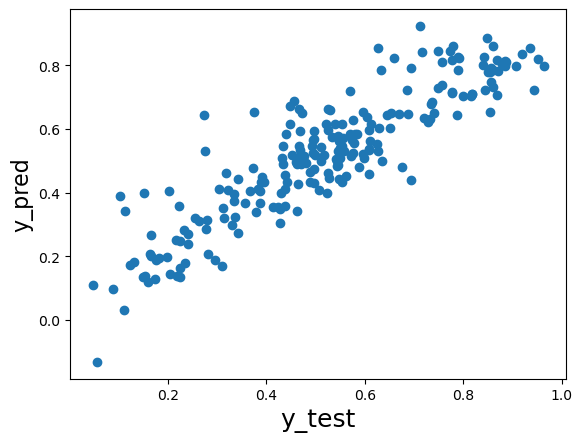

In [72]:
plt.scatter(y_test, y_test_pred)
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)  
plt.show()

In [75]:
round(lm6.params,4).sort_values(ascending=False)

temp               0.5499
yr                 0.2331
winter             0.1318
September          0.0972
summer             0.0874
const              0.0753
Saturday           0.0677
workingday         0.0563
Misty+Cloudy      -0.0813
windspeed         -0.1552
Light Snow/Rain   -0.2880
dtype: float64

#### Suggestion to BoomBikes Management

Based on the model obtained we can conclude  that below three features are the most influential features for BIke Rentals:
- Temperature : with coefficient **0.5499**
- Year:  with coefficient **0.2331**
- Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds: with negative coefficient **-0.2880**

## Equation of our best fitted line is
### **cnt** =0.0753 + 0.5499 * temp + 0.2331 * yr + 0.1318 * winter + 0.0972 * September + 0.0874 * summer + 0.0677 * Saturday + 0.0563 * workingday - 0.0813 * (Misty+Cloudy) - 0.1552 * windspeed - 0.2880 * (Light Snow/Rain)  

### R squared value of both Training and test data set

### - Train dataset R^2          : 0.836
### - Test dataset R^2           : 0.7956
